# Mnist attempt


## 导入包

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader                 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils

import matplotlib.pyplot as plt
from PIL import Image


#from torchvision.models import vgg16,vgg16_bn

## 启用显卡(if gpu exists)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## 参数设置

In [3]:
# 超参
random_seed=1
learning_rate=0.001
batch_size=128
num_epoch=10
momentum=0.9

num_features=32*32
num_classes=10
grayscale=True

## 下载数据集

In [4]:
transform=transforms.Compose([transforms.Resize((32,32)),
                              transforms.ToTensor()])

train_dataset=datasets.MNIST(root='./data',
                             train=True,
                             transform=transform,
                             download=True)

test_dataset=datasets.MNIST(root='./data',
                            train=False,
                            transform=transform,
                            download=True)

train_loader=DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader=DataLoader(dataset=test_dataset,
                       batch_size=batch_size,
                       shuffle=False)


for images,labels in train_loader:
    print("image batch dimensions:",images.shape)
    print("image label dimensions:",labels.shape)
    break

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




image batch dimensions: torch.Size([128, 1, 32, 32])
image label dimensions: torch.Size([128])


## vgg16


~~trainmodel=vgg16()~~
~~print(trainmodel)~~

VGG( \
  (features): Sequential( \
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (1): ReLU(inplace=True) \
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (3): ReLU(inplace=True) \
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) \
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (6): ReLU(inplace=True) \
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (8): ReLU(inplace=True) \
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  \ 
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  \
    (11): ReLU(inplace=True)  \
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (13): ReLU(inplace=True)  \ 
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (15): ReLU(inplace=True) \
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) \ 
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (18): ReLU(inplace=True) \ 
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (20): ReLU(inplace=True) \
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (22): ReLU(inplace=True) \
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) \
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (25): ReLU(inplace=True) \
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \
    (27): ReLU(inplace=True) \
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) \ 
    (29): ReLU(inplace=True) \
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) \
  )   
     
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7)) \
     
  (classifier): Sequential( \
    (0): Linear(in_features=25088, out_features=4096, bias=True) \
    (1): ReLU(inplace=True) \
    (2): Dropout(p=0.5, inplace=False) \
    (3): Linear(in_features=4096, out_features=4096, bias=True) \
    (4): ReLU(inplace=True) \
    (5): Dropout(p=0.5, inplace=False)   
    (6): Linear(in_features=4096, out_features=1000, bias=True)   
 )   
)

## 实现类

In [5]:
class Net(nn.Module):

    def __init__(self,num_classes,grayscale=False):
      super(Net,self).__init__()
      
      self.grayscale=grayscale
      self.num_classes=num_classes

      if self.grayscale:
        input_channels=1
      else:
        input_channels=3
      
      self.features=nn.Sequential(
          nn.Conv2d(input_channels,6,kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(6,16,kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
      )
      
      self.classifier=nn.Sequential(
          nn.Linear(16*5*5,120),
          nn.ReLU(),
          nn.Linear(120,84),
          nn.ReLU(),
          nn.Linear(84,num_classes),
      )

    def forward(self,x):
          x=self.features(x)
          x=torch.flatten(x,1)
          logits=self.classifier(x)
          probas=F.softmax(logits,dim=1)
          return logits,probas

In [6]:
torch.manual_seed(random_seed)
net=Net(num_classes,grayscale)
net.to(device)

#optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate)    #adam优化
optimizer=torch.optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

## 训练

In [7]:
def compute_accuracy(net,data_loader,device):
  correct_pred,num_sample=0,0
  for i,data in enumerate(data_loader,0):
    images,labels=data[0].to(device),data[1].to(device)

    output,probas=net(images)
    _,predicted_labels=torch.max(probas,1)
    num_sample+=labels.size(0)
    correct_pred+=(predicted_labels==labels).sum()
  return correct_pred.float()/num_sample*100


start_time=time.time()
tmp=time.time()
for epoch in range(num_epoch):

    net.train()

    for  batch_idx,data in enumerate(train_loader,0):
      inputs,labels=data[0].to(device),data[1].to(device)

      output,probas=net(inputs)           #forward

      loss=F.cross_entropy(output,labels)
      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

      if not batch_idx % 50:
        print('Epoch:%03d/%03d   | Batch Blocks: %4d/%4d   | Loss:%.3f'%(
            epoch+1,num_epoch,batch_idx,
            len(train_loader),loss
        ))

    net.eval() 
    with torch.set_grad_enabled(False):
      print('Epoch: %03d/%03d   | Train: %.3f%%'%(
        epoch+1,num_epoch,
        compute_accuracy(net,train_loader,device=device)
      ))   
    print('Time consume: %.2f min'%((time.time()-tmp)/60))
    tmp=time.time()

print('total Time: %.2f min'%(
    (time.time()-start_time)/60
    )
)

Epoch:001/010   | Batch Blocks:    0/ 469   | Loss:2.301
Epoch:001/010   | Batch Blocks:   50/ 469   | Loss:2.296
Epoch:001/010   | Batch Blocks:  100/ 469   | Loss:2.307
Epoch:001/010   | Batch Blocks:  150/ 469   | Loss:2.297
Epoch:001/010   | Batch Blocks:  200/ 469   | Loss:2.294
Epoch:001/010   | Batch Blocks:  250/ 469   | Loss:2.292
Epoch:001/010   | Batch Blocks:  300/ 469   | Loss:2.290
Epoch:001/010   | Batch Blocks:  350/ 469   | Loss:2.294
Epoch:001/010   | Batch Blocks:  400/ 469   | Loss:2.281
Epoch:001/010   | Batch Blocks:  450/ 469   | Loss:2.265
Epoch: 001/010   | Train: 34.027%
Time consume: 0.23 min
Epoch:002/010   | Batch Blocks:    0/ 469   | Loss:2.269
Epoch:002/010   | Batch Blocks:   50/ 469   | Loss:2.256
Epoch:002/010   | Batch Blocks:  100/ 469   | Loss:2.231
Epoch:002/010   | Batch Blocks:  150/ 469   | Loss:2.225
Epoch:002/010   | Batch Blocks:  200/ 469   | Loss:2.093
Epoch:002/010   | Batch Blocks:  250/ 469   | Loss:2.010
Epoch:002/010   | Batch Blocks:

# 测试

In [8]:
with torch.set_grad_enabled(False):
  print('Test accutacy: %.2f%% '%(compute_accuracy(net,test_loader,device=device)))

Test accutacy: 96.86% 


## 保存模型

In [11]:
PATH='./mnist_attempt.pth'
torch.save(net.state_dict(),PATH)

### 显示测试

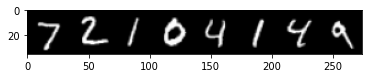

predict the Number is: 

           7            2            1            0            4            1            4            9
Predicted:
             7            2            1            0            4            1            4            9


In [21]:
import torchvision
classes=('0','1','2','3','4','5','6','7','8','9')
nums=8

dataiter=iter(test_loader)
images,labels=dataiter.next()

net=Net(num_classes,grayscale)
net.to(device)
net.load_state_dict(torch.load(PATH))
net.eval()
outputs,probas=net(images.to(device))
with torch.set_grad_enabled(False):
    _, predicted = torch.max(probas, 1)

images=torchvision.utils.make_grid(images[:nums])
img=images.numpy()
plt.imshow(img.transpose(1,2,0))
plt.show()

_,predicted=torch.max(outputs,1)
print('predict the Number is: \n')
print(' '.join('%12s'%classes[predicted[i]]
               for i in range(nums)
               )
)
print('Predicted:\n ', ' '.join('%12s' % classes[predicted[j]]
                              for j in range(nums)))

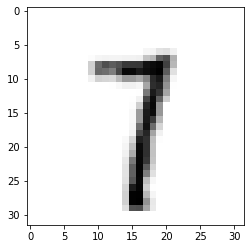

predict the Number is: 7


In [22]:
dataiter=iter(train_loader)
images,labels=dataiter.next()
img=images[0].numpy()
plt.imshow(img.reshape(32,32),cmap='gray_r')
plt.show()
print('predict the Number is: %s'%(classes[labels[0]]))